In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import torch
import yaml
from torch.utils.data import DataLoader
from pytorch_msssim import ms_ssim
from utils import *
import matplotlib.pyplot as plt
import torch.nn.utils.spectral_norm as spectralnorm
from torch.nn import init
import torchvision
import torch
import torch.nn as nn
from models import *
from utils import *
import torch.nn.functional as F
import glob
from kth import KTHDataset
from helper import *


import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt 


/home/truongbuu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/truongbuu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def to_numpy(x):
    return x.detach().cpu().numpy()

def hwc(x):
    return np.transpose(x, (0, 2,3,1))

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0),  1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake[:,0],
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def cal_W1(encoder, decoder, discriminator_M, test_loader):
    mse_loss = nn.MSELoss(reduction='sum')

    encoder.eval()
    decoder.eval()
    discriminator_M.eval()
    
    W1M_distance = []
    MSE = []

    num_x = 0
    for i, data in enumerate(iter(test_loader)):
        with torch.no_grad():
            x = data[0].permute(0, 2, 1, 3, 4)
            x = x.cuda().float()
            hx = encoder(x[:,:,0,:,:])
            x_hat =  decoder(hx[0])
            
            fake_img = x_hat.detach()
            real_img = x[:,0,:1,...].detach()
            fake_valid_m = discriminator_M(fake_img)
            real_valid_m = discriminator_M(real_img)

            W1M_distance.append(torch.sum(real_valid_m) - torch.sum(fake_valid_m))
            #print (F.mse_loss(x[:,:,1,:,:], x_hat)* x.size()[0])
            MSE.append(mse_loss(x[:,:,0,:,:], x_hat))
            #print (mse_loss(x[:,:,1,:,:], x_hat)/(64*64*len(x)))
            num_x += len(x)

    W1M_distance = torch.Tensor(W1M_distance)
    MSE = torch.Tensor(MSE)

    return W1M_distance.sum()/num_x, MSE.sum()/(num_x*64*64)

def cal_W1_ssf(encoder, decoder, decoder_hat, ssf, discriminator, dataloader):
    ssf.eval()
    encoder.eval()
    decoder.eval()
    decoder_hat.eval()
    
    mse_loss = nn.MSELoss()
    
    MSE = 0
    W1 = []
    for i, data in enumerate(dataloader, 0):
        ###########################
        # train with real
        
        with torch.no_grad():
            x = data[0][:,:,:,:,:]
            x = x.cuda()
            x = 2*(x-0.5)
            batch_size = x.size(0)
            x1 = x[:,0,...]
            x2 = x[:,1,...]
        
            #Compressor
            z = encoder(x1)[0]
            z = z.view(batch_size, I_dim, 1, 1)
            x_1_hat = decoder_hat(z).detach()
            x_1_bar = decoder(z).detach()
            
            x_hat = ssf(x2, x_1_bar, x_1_hat)
        
        
        
            real_vid = torch.cat((x1,x2), dim=1).detach()
            fake_vid = torch.cat((x_1_hat, x_hat),dim=1).detach()
            output_real = discriminator(real_vid)
            output_fake = discriminator(fake_vid) 
        
        MSE+= mse_loss(x2, x_hat).item()
        W1.append(torch.sum(output_real)-torch.sum(output_fake))
        
    #MSE = torch.Tensor(MSE)
    W1 = torch.Tensor(W1)
    
    return W1.sum()/len(dataloader.dataset), MSE/(len(dataloader.dataset))
        


In [3]:
class Decoder_KTH(nn.Module):
    def __init__(self, dim, ngpu=1,nc=3, ngf=64):
        super(Decoder_KTH, self).__init__()
        self.ngpu = ngpu
        nz = dim
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [4]:
z_dim=8
L=2

ssf = ScaleSpaceFlow_R1eps_universal_KTH(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=L)
discriminator_P2 = Discriminator_KTH_dataset_wgan(nc=6)

discriminator_P2.cuda()
ssf.cuda()

opt_ssf= torch.optim.RMSprop(ssf.parameters(), lr=1e-3)
opt_d= torch.optim.RMSprop(discriminator_P2.parameters(), lr=2e-4)


[-1.0, 1.0]


In [5]:
traindataset = KTHDataset(seq_len=2, train=True)
testdataset = KTHDataset(seq_len=2, train=False)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=64, shuffle=True)


I_dim = 16 #12 #8
I_L = 2
lambda_gp = 10


encoder = Encoder(dim=I_dim, nc=3, stochastic=True, quantize_latents=True, L=I_L) #Generator Side
decoder = Decoder_KTH(dim=I_dim) #Generator Side
decoder_hat = Decoder_KTH(dim=I_dim)
#discriminator_M = Discriminator_KTH_dcgan(nc=3) #Marginal Discriminator





encoder.cuda()
decoder.cuda()
decoder_hat.cuda()
#discriminator_M.cuda()


encoder.eval()
decoder.eval()
decoder_hat.eval()

#opt_e = torch.optim.Adam(encoder.parameters(), lr=1e-3)
#opt_g = torch.optim.Adam(decoder.parameters(), lr=1e-3)
#opt_g_hat = torch.optim.Adam(decoder_hat.parameters(), lr=1e-3)
#opt_dm = torch.optim.RMSprop(discriminator_M.parameters(), lr=1e-4) #Marginal Discriminator

[-1.0, 1.0]


Decoder_KTH(
  (main): Sequential(
    (0): ConvTranspose2d(16, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [6]:
for i, data in enumerate(train_loader, 0):
    x = data[0][:,:,:,:,:]
    x = x.cuda()
    x = 2*(x-0.5)
    batch_size = x.size(0)
    
    x1= x[:,0,...]
    break


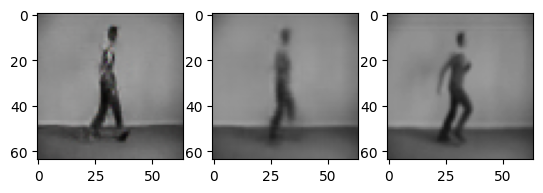

In [9]:
decoder.load_state_dict(torch.load("./KTH_I_frame_wgan/mse_dec.pth"))
decoder_hat.load_state_dict(torch.load("./KTH_I_frame_wgan/P_dec_hat.pth"))
encoder.load_state_dict(torch.load("./KTH_I_frame_wgan/mse_enc.pth"))
idx = 21
with torch.no_grad():
    z = encoder(x1)[0]
    z = z.view(batch_size, I_dim, 1, 1)
    x_hat = decoder_hat(z)
    x_bar = decoder(z)

plt.subplot(1,3,1)
plt.imshow((hwc(to_numpy(x_hat))[idx]+1)/2)
plt.subplot(1,3,2)
plt.imshow((hwc(to_numpy(x_bar))[idx]+1)/2)
plt.subplot(1,3,3)
plt.imshow((hwc(to_numpy(x1))[idx]+1)/2)

In [ ]:
mse_loss = nn.MSELoss(reduce='mean')
real_label = 1
fake_label = 0
criterion = nn.BCELoss()
#initial value: 0.5 -(tensor(2.4168), 0.0002200380973853159)
#0.05 (tensor(2.3469), 0.00021562142142306215)
#0.01 tensor(2.5469), 0.0001784170898850669
#0.001 fails after 5 epochs: (tensor(4.0798), 0.00010077650030536678)
lambda_P=0.01 #1 #tomorrow: try 0.005 0.01

ssf.freeze_enc=True
ssf.motion_encoder.eval()
ssf.motion_decoder.eval()
ssf.P_encoder.eval()
ssf.res_encoder.eval()
ssf.res_decoder.eval()

for epoch in range(200):
    loss_train = 0
    errD =0
    for i, data in enumerate(train_loader, 0):
        opt_d.zero_grad()
        opt_ssf.zero_grad()
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        x = data[0][:,:,:,:,:]
        x = x.cuda()
        x = 2*(x-0.5)
        batch_size = x.size(0)
        
        
        x1 = x[:,0,...]
        x2 = x[:,1,...]
        
        
        
        with torch.no_grad():
            #Compressor
            z = encoder(x1)[0]
            z = z.view(batch_size, I_dim, 1, 1)
            x_1_hat = decoder_hat(z).detach()
            x_1_bar = decoder(z).detach()
            
        x_hat = ssf(x2, x_1_bar, x_1_hat)
        
        real_vid = torch.cat((x1,x2), dim=1).detach()
        fake_vid = torch.cat((x_1_hat, x_hat),dim=1).detach()
        
        
        output_real = discriminator_P2(real_vid)
        output_fake = discriminator_P2(fake_vid) 
        
        gradient_penalty_m=compute_gradient_penalty(discriminator_P2, fake_vid.data, real_vid.data)
        errDG =  -torch.mean(output_real) + torch.mean(output_fake) + 20 * gradient_penalty_m
        errDG.backward()
        opt_d.step()
        
        if i%5 == 0:
            x1 = x[:,0,...].detach()
            x2 = x[:,1,...].detach()

            with torch.no_grad():
                #Compressor
                z = encoder(x1)[0]
                z = z.view(batch_size, I_dim, 1, 1)
                x_1_hat = decoder_hat(z).detach()
                x_1_bar = decoder(z).detach()

            x_hat = ssf(x2, x_1_bar, x_1_hat)
            
            fake_vid = torch.cat((x_1_hat, x_hat),dim=1)
            output_hat = discriminator_P2(fake_vid)
            errG =  -torch.mean(output_hat) 
            
            loss_mse = mse_loss(x_hat, x2) + lambda_P*errG
            
            loss_mse.backward()

            opt_ssf.step()
            loss_train += mse_loss(x_hat, x2).item()
        
        #print (D_x, D_G_z1)
    if epoch%5==0:
        print ('EPOCH: ', epoch)
        print (cal_W1_ssf(encoder, decoder, decoder_hat, ssf, discriminator_P2, train_loader))
        print (cal_W1_ssf(encoder, decoder, decoder_hat, ssf, discriminator_P2, test_loader))
        print ('-----------------------------------------')
        #print (5*loss_train/(len(train_loader.dataset)))
        #print (torch.mean(output_real) - torch.mean(output_fake))

/home/truongbuu/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/tmp/ipykernel_33020/711943845.py:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  alpha = Tensor(np.random.random((real_samples.size(0),  1, 1, 1)))


EPOCH:  0
(tensor(418.5495), 0.016326938630308683)
